# Training the Model

This notebook builds a classification model to predict the outcome of football matches using engineered features from historical team performance data. The model is trained using CatBoost, a gradient boosting algorithm that handles missing values and categorical features natively. The goal is to classify match results as home win, away win, or draw based on team strength, form, and other match statistics.

### Imports

In [40]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

match_data = pd.read_csv("../data/training_data.csv")

match_data=match_data.drop(columns=['DATE'],axis=1)

print(match_data.dtypes)
print(match_data.columns.tolist())
match_data.head()

HOME_TEAM                      object
HOME_STRENGTH                 float64
HOME_LEAGUE_STRENGTH          float64
HOME_GOALS_FOR_LAST3          float64
HOME_GOALS_AGAINST_LAST3      float64
HOME_STRENGTH_LAST3           float64
HOME_LEAGUE_STRENGTH_LAST3    float64
HOME_TARGET_LAST3             float64
HOME_FOULS_LAST3              float64
HOME_CORNERS_LAST3            float64
HOME_YELLOW_LAST3             float64
HOME_RED_LAST3                float64
HOME_FORM_LAST3               float64
AWAY_TEAM                      object
AWAY_STRENGTH                 float64
AWAY_LEAGUE_STRENGTH          float64
AWAY_GOALS_FOR_LAST3          float64
AWAY_GOALS_AGAINST_LAST3      float64
AWAY_STRENGTH_LAST3           float64
AWAY_LEAGUE_STRENGTH_LAST3    float64
AWAY_TARGET_LAST3             float64
AWAY_FOULS_LAST3              float64
AWAY_CORNERS_LAST3            float64
AWAY_YELLOW_LAST3             float64
AWAY_RED_LAST3                float64
AWAY_FORM_LAST3               float64
RESULT      

,HOME_TEAM,HOME_STRENGTH,HOME_LEAGUE_STRENGTH,HOME_GOALS_FOR_LAST3,HOME_GOALS_AGAINST_LAST3,HOME_STRENGTH_LAST3,HOME_LEAGUE_STRENGTH_LAST3,HOME_TARGET_LAST3,HOME_FOULS_LAST3,HOME_CORNERS_LAST3,...,AWAY_CORNERS_LAST3,AWAY_YELLOW_LAST3,AWAY_RED_LAST3,AWAY_FORM_LAST3,RESULT,STRENGTH_DIFF,LEAGUE_STRENGTH_DIFF,FORM_DIFF,HOME_GOAL_DIFF_LAST3,AWAY_GOAL_DIFF_LAST3
0,AFC Ajax,84.3,76.2,3.000000,0.666667,84.3,76.2,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,H,-4.5,-2.4,0.0,2.333333,2.000000
1,AFC Ajax,84.3,76.2,2.666667,1.666667,84.3,76.2,NaN,NaN,NaN,...,7.333333,2.000000,0.333333,9.0,A,-4.7,-2.4,0.0,1.000000,1.333333
2,AVS,75.7,78.6,1.333333,2.000000,75.7,78.6,3.000000,12.000000,2.666667,...,6.000000,1.000000,0.333333,3.0,H,-2.6,0.0,0.0,-0.666667,0.000000
3,AVS,75.7,78.6,0.333333,1.333333,75.7,78.6,1.000000,12.666667,4.666667,...,5.000000,2.666667,0.000000,2.0,A,-8.5,0.0,0.0,-1.000000,2.666667
4,AVS,75.7,78.6,0.333333,2.000000,75.7,78.6,1.333333,11.333333,5.000000,...,6.333333,1.666667,0.000000,7.0,A,-4.7,0.0,0.0,-1.666667,-1.000000


### Set Target and Categorical Features

In [41]:
# Define target and features
target_col = "RESULT"
categorical_cols = ["HOME_TEAM", "AWAY_TEAM"]

X = match_data.drop(columns=[target_col])
y = match_data[target_col]

### Training Testing Split

In [42]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# Create CatBoost Pool objects for better performance
train_pool = Pool(X_train, y_train, cat_features=categorical_cols)
test_pool = Pool(X_test, y_test, cat_features=categorical_cols)

### Train Model

In [43]:
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    verbose=100,
    random_seed=42
)

model.fit(train_pool, eval_set=test_pool)


0:	learn: 0.5043382	test: 0.4965646	best: 0.4965646 (0)	total: 40.2ms	remaining: 20.1s
100:	learn: 0.5230096	test: 0.5078076	best: 0.5103061 (77)	total: 5.26s	remaining: 20.8s
200:	learn: 0.5355730	test: 0.5090568	best: 0.5171768 (137)	total: 10.7s	remaining: 15.9s
300:	learn: 0.5498716	test: 0.5078076	best: 0.5171768 (137)	total: 15.6s	remaining: 10.3s
400:	learn: 0.5652808	test: 0.5065584	best: 0.5171768 (137)	total: 21.6s	remaining: 5.34s
499:	learn: 0.5809676	test: 0.5034354	best: 0.5171768 (137)	total: 27s	remaining: 0us

bestTest = 0.5171767645
bestIteration = 137

Shrink model to first 138 iterations.


### Feature Selection

As we can see, that the Accuracy is around 50% which is the same as random guess. So now we should try to possibly reduce the number of features that may be resulting in the model getting confused.

,Feature Id,Importances
0,STRENGTH_DIFF,31.181165
1,HOME_TEAM,13.954631
2,AWAY_TEAM,11.931546
3,AWAY_STRENGTH_LAST3,3.453369
4,HOME_GOAL_DIFF_LAST3,2.878615
5,AWAY_STRENGTH,2.471890
6,HOME_LEAGUE_STRENGTH,2.379823
7,HOME_STRENGTH,2.364734
8,AWAY_GOALS_FOR_LAST3,2.316087
9,HOME_GOALS_FOR_LAST3,2.250090


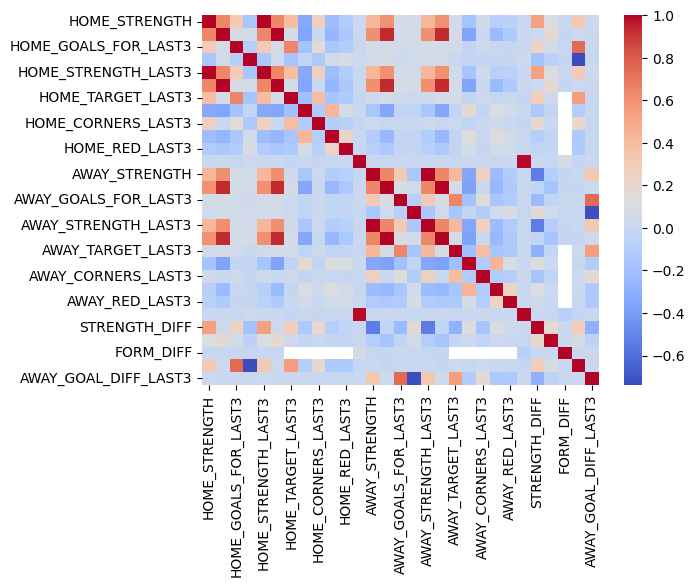

In [46]:
model.get_feature_importance(prettified=True)

numeric_data = match_data.select_dtypes(include=["number"])
sns.heatmap(numeric_data.corr(), annot=False, cmap='coolwarm')

model.get_feature_importance(prettified=True)

### Train a New Model, With Subset of Features

I am also going to change the target, as two-level classification is easier than three-level. So the outcomes will now be Home Win or No Home Win

In [49]:
drop_cols = [
    "HOME_YELLOW_LAST3",
    "HOME_CORNERS_LAST3",
    "AWAY_CORNERS_LAST3",
    "AWAY_YELLOW_LAST3",
    "HOME_FOULS_LAST3",
    "AWAY_FOULS_LAST3",
    "AWAY_RED_LAST3",
    "HOME_RED_LAST3",
    "FORM_DIFF",

]

# Create binary label: 1 if home team wins, 0 otherwise
match_data['HOME_WIN'] = match_data['RESULT'].apply(lambda x: 1 if x == 'H' else 0)

# Create a new dataframe without those columns + columns to exclude like teams, date, home win
X = match_data.drop(columns=drop_cols + ["HOME_TEAM", "AWAY_TEAM", "HOME_WIN","RESULT"])

# Target column
y = match_data["HOME_WIN"]

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

from catboost import CatBoostClassifier, Pool

# Optional: specify categorical features by index if you have any categorical columns
categorical_features = []  # add indices or names if you have any

train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

# Initialize and train model
model = CatBoostClassifier(iterations=500, eval_metric='Accuracy', random_seed=42, verbose=100)
model.fit(train_pool, eval_set=test_pool, use_best_model=True)

# Evaluate
from sklearn.metrics import classification_report, accuracy_score
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Learning rate set to 0.082799
0:	learn: 0.6273339	test: 0.6133666	best: 0.6133666 (0)	total: 41.9ms	remaining: 20.9s
100:	learn: 0.6652322	test: 0.6383510	best: 0.6396002 (96)	total: 727ms	remaining: 2.87s
200:	learn: 0.6855001	test: 0.6333542	best: 0.6402249 (152)	total: 1.35s	remaining: 2s
300:	learn: 0.7041022	test: 0.6333542	best: 0.6402249 (152)	total: 1.95s	remaining: 1.29s
400:	learn: 0.7247866	test: 0.6302311	best: 0.6402249 (152)	total: 2.56s	remaining: 632ms
499:	learn: 0.7413063	test: 0.6289819	best: 0.6402249 (152)	total: 3.16s	remaining: 0us

bestTest = 0.6402248595
bestIteration = 152

Shrink model to first 153 iterations.
Accuracy: 0.6402248594628357
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       896
           1       0.62      0.47      0.53       705

    accuracy                           0.64      1601
   macro avg       0.64      0.62      0.62      1601
weighted avg       0.64      0.64      0.63      1601
